# **Phase 2**: Functional Group Feature Extraction using RDkit


This process converts SMILES representations of molecules into quantitative, interpretable features by extracting:

- Functional group counts (e.g., alcohols, amines, carbonyls)
- Atomic composition features (counts of C, H, O, N, F)
- Combines these with quantum property targets from QM9 dataset

The extracted dataset is used for next phases (Classic Machine Learning + NN Algorithm).


## Procedure Summary

1. **Functional Group Catalog Initialization**

   - Uses RDKit’s `FunctionalGroups.txt` SMARTS catalog to define ~100 functional groups.
   - Loads catalog with `FragmentCatalog.FragCatParams` and initializes detection tool.

2. **SMILES Parsing and Feature Extraction**

   - Each SMILES string is converted to a Mol object with `Chem.MolFromSmiles`.
   - Scans Mol object against catalog patterns.
   - Counts matches for each functional group and stores them in a dictionary.
   - Atom counts (C, H, N, O, F, etc.) are added.

3. **Dataset Assembly**

   - Functional group counts and atomic counts for each molecule are stored.
   - Quantum properties (from the previous chapter) are merged with this feature set.

4. **Error Handling**

   - Molecules with invalid SMILES or parsing failures are skipped.
   - Missing values filled with zero.
   - Outputs dataset to CSV file.


## Code Explanation

### 1. Imports

- `pandas` → handles dataset read/write
- `rdkit.Chem` → parses SMILES into Mol objects
- `rdkit.Chem.FragmentCatalog` → loads and applies functional group definitions
- `os`, `Counter` → file handling and atom counting

### 2. Function `extract_functional_group_counts(smiles)`

**Purpose:**  
Extracts functional group and atomic counts from a single SMILES string.

**Steps:**  
- Loads RDKit’s functional group catalog definitions.
- Parses SMILES string into Mol object.
- For each catalog entry:
  - Matches substructures in the molecule.
  - Counts frequency of each functional group.
- Counts atom types (C, H, O, N, etc.) and merges with functional group data.
- Returns combined counts as a Pandas Series.

### 3. Main Loop

- Reads dataset of molecules (`qm9_dataset.csv`), collects SMILES list.
- For each SMILES:
  - Calls `extract_functional_group_counts`.
  - Appends counts to list.


### 4. Final Dataset Assembly

- Combines all counts into DataFrame.
- Fills missing values with 0.
- Merges quantum chemical properties (`mu`, `alpha`, `homo`, etc.) into final DataFrame.
- Saves dataset to `dataset_9May.csv`.


**Notes**
- Functional groups are only counted if detected (sparse feature space).
- RDKit’s catalog can be edited to include custom SMARTS patterns or aggregated categories.
- This approach yields interpretable chemical features suitable for ML models and chemical analysis.


In [ ]:
# Read a CSV file containing the Refined QM9 dataset
import pandas as pd
df = pd.read_csv('qm9_dataset.csv')
df.head()

,index,smiles,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,3895,O=C1C=CON=N1,3.3067,46.55,-0.2630,-0.0607,0.2023,965.3567,0.049003,-375.430225,-375.421157,-375.420213,-375.469933,24.943
1,3896,O=C1C=NOC=N1,2.4177,46.66,-0.2701,-0.0861,0.1840,567.5171,0.055941,-375.359188,-375.354066,-375.353122,-375.388412,17.987
2,3897,O=C1C=NON=C1,0.2386,48.24,-0.2681,-0.1008,0.1674,577.0287,0.054950,-375.307060,-375.301908,-375.300964,-375.336105,18.514
3,3898,O=C1C=NON=N1,1.5473,45.28,-0.2714,-0.1200,0.1514,556.6358,0.041330,-391.337881,-391.332272,-391.331328,-391.367925,19.012
4,3899,O=C1N=CON=N1,1.7309,41.79,-0.2961,-0.0570,0.2391,913.3757,0.038631,-391.518453,-391.509552,-391.508608,-391.558096,23.419


In [ ]:
# Extract the 'smiles' column and convert it to a list
smiles_list = df['smiles'].tolist()

In [ ]:
from rdkit import Chem, RDConfig
from rdkit.Chem import FragmentCatalog
import os
import pandas as pd
from collections import Counter

# Function to extract functional group counts from SMILES strings using RDKit
def extract_functional_group_counts(smiles):
    fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt') # Read the functional group definitions from RDKit's data directory
    # load *all* the functional‐group patterns
    fparams = FragmentCatalog.FragCatParams(1, 6, fName)

    # create a molecule from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # unparseable SMILES
        return pd.Series({'Molecule': smiles})

    functional_group_counts = {}        # Preallocate a dictionary to hold functional group counts

    # loop over every predefined functional group
    for fid in range(fparams.GetNumFuncGroups()):  # :contentReference[oaicite:0]{index=0}
        pattern = fparams.GetFuncGroup(fid)
        # human‐readable name (fallback to SMARTS if no _Name)
        name = pattern.GetProp('_Name') if pattern.HasProp('_Name') else Chem.MolToSmarts(pattern)
        # find *all* matches of that pattern in the molecule
        matches = mol.GetSubstructMatches(pattern)  # :contentReference[oaicite:1]{index=1}
        count = len(matches)
        if count:
            functional_group_counts[name] = count

    # tack on atom counts as before
    atom_types = Counter(atom.GetSymbol() for atom in mol.GetAtoms())
    functional_group_counts.update(atom_types)
    functional_group_counts['Molecule'] = smiles

    return pd.Series(functional_group_counts)


# Example usage with the corrected SMILES
#smiles_list = ['O=C1C=CON=N1', 'CCO', 'CC(=O)O', 'c1ccccc1[N+](=O)[O-]', 'O=C(O)C(=O)O']
all_molecule_counts = []        # Preallocate a list to hold counts for all molecules

# Iterate over the list of SMILES strings and extract functional group counts
for smiles in smiles_list:
    counts = extract_functional_group_counts(smiles)
    all_molecule_counts.append(counts)

final_df = pd.DataFrame(all_molecule_counts).fillna(0).set_index('Molecule')

print(final_df)


               =O    O  C    N   -O   =N  =N-O  -tBu  -C(=O)H  -C(=O)CH3  ...  \
Molecule                                                                  ...   
O=C1C=CON=N1  1.0  2.0  3  2.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
O=C1C=NOC=N1  1.0  2.0  3  2.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
O=C1C=NON=C1  1.0  2.0  3  2.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
O=C1C=NON=N1  1.0  2.0  2  3.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
O=C1N=CON=N1  1.0  2.0  2  3.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
...           ...  ... ..  ...  ...  ...   ...   ...      ...        ...  ...   
N#CC1=NCCCO1  0.0  1.0  5  2.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
C#CC1CC=CCO1  0.0  1.0  7  0.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
C#CC1CCC=CC1  0.0  0.0  8  0.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
C#CC1CCN=CO1  0.0  1.0  6  1.0  0.0  0.0   0.0   0.0      0.0        0.0  ...   
C#CC1COC=NC1  0.0  1.0  6  1

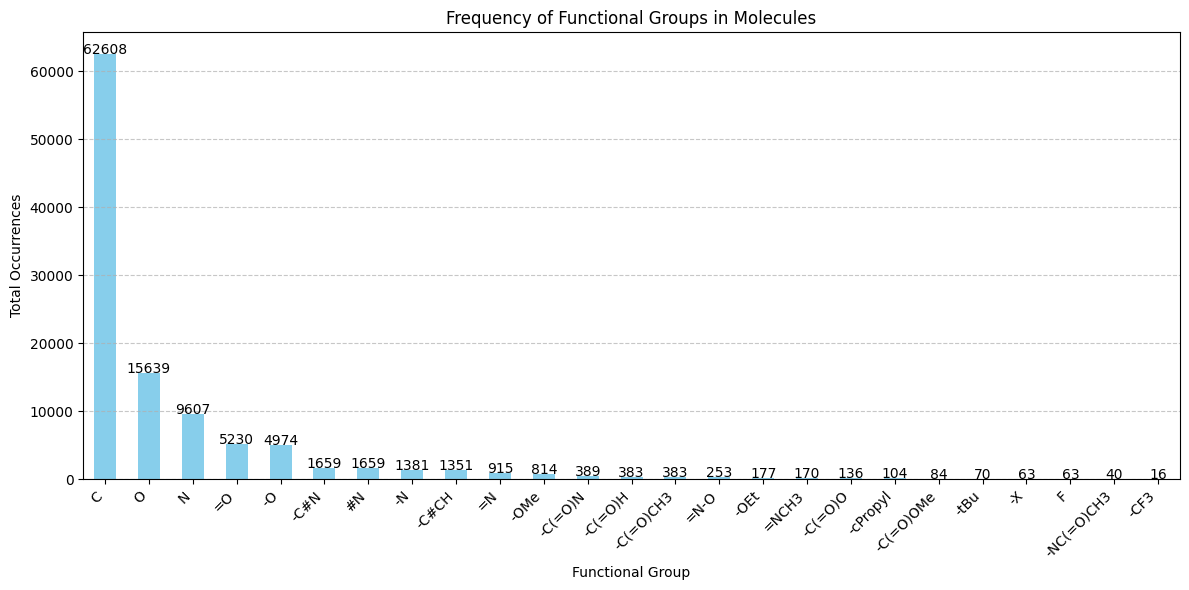

In [4]:
import matplotlib.pyplot as plt

# Sum the occurrences of each functional group across all molecules
func_group_totals = final_df.sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
func_group_totals.plot(kind='bar', color='skyblue')
plt.title('Frequency of Functional Groups in Molecules')
plt.xlabel('Functional Group')
plt.ylabel('Total Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optionally, add value labels on top of each bar
for i, v in enumerate(func_group_totals):
    plt.text(i, v + 0.1, f'{int(v)}', ha='center')

plt.show()


In [7]:
# Extract energy values (U0, U, H, G, Cv) from df
energy_values = df[['smiles','mu','alpha','homo','lumo','gap','r2','zpve', 'U0', 'U', 'H', 'G', 'Cv']].set_index('smiles')

# Update the final_df with these energy values
final_df[['mu','alpha','homo','lumo','gap','r2','zpve', 'U0', 'U', 'H', 'G', 'Cv']] = energy_values.loc[final_df.index]

# Display the first few rows to confirm the update
final_df.head()
# Save the final DataFrame to a CSV file
final_df.to_csv('dataset_9May.csv', index=True)

In [ ]:
final_df.head()

,=O,O,C,N,-O,=N,=N-O,-tBu,-C(=O)H,-C(=O)CH3,...,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
Molecule,,,,,,,,,,,,,,,,,,,,,
O=C1C=CON=N1,1.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2630,-0.0607,0.2023,965.3567,0.049003,-375.430225,-375.421157,-375.420213,-375.469933,24.943
O=C1C=NOC=N1,1.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2701,-0.0861,0.1840,567.5171,0.055941,-375.359188,-375.354066,-375.353122,-375.388412,17.987
O=C1C=NON=C1,1.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2681,-0.1008,0.1674,577.0287,0.054950,-375.307060,-375.301908,-375.300964,-375.336105,18.514
O=C1C=NON=N1,1.0,2.0,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2714,-0.1200,0.1514,556.6358,0.041330,-391.337881,-391.332272,-391.331328,-391.367925,19.012
O=C1N=CON=N1,1.0,2.0,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2961,-0.0570,0.2391,913.3757,0.038631,-391.518453,-391.509552,-391.508608,-391.558096,23.419
